# Demo GPU computation with CUDA
* `iqwaveform` and `edge_analyzer` have been developed to accept `numpy` (CPU) or `cupy` (CUDA GPU) arrays interchangeably
* This shows the evaluation on a Jetson TX2
* Beginning from the `Channel power time-series` section, the code cells are identical to the CPU (numpy) compute notebook

### Generate fake data

In [1]:
from edge_analyzer.io import simulated_awgn
import cupy as cp
import iqwaveform.cuda

# this takes a while the first time, so get it out of the way now
iqwaveform.cuda.build()

### Analysis bandpass filter

In [2]:
from edge_analyzer import channel_waveform
from scipy import signal
from edge_analyzer import cuda_filter
from iqwaveform import fourier
from cupyx.profiler import benchmark
from edge_analyzer.io import simulated_awgn
import cupy as cp

import importlib
fourier = importlib.reload(fourier)

duration = 0.2
sample_rate_Hz = 15.36e6  # 11.52e6
analysis_bandwidth_Hz = 10e6

raw_iq = simulated_awgn(
    duration, sample_rate_Hz, power=sample_rate_Hz / analysis_bandwidth_Hz, xp=cp
)
iq = fourier.ola_filter(
    raw_iq,
    fs=sample_rate_Hz,
    noverlap=512,
    window='hamming',
    passband=(-analysis_bandwidth_Hz / 2, analysis_bandwidth_Hz / 2),
)

cp.cuda.runtime.deviceSynchronize()

In [24]:
def profile():
    ret = fourier.ola_filter(raw_iq, fs=sample_rate_Hz, noverlap=512, window='hamming', passband=(-analysis_bandwidth_Hz/2, analysis_bandwidth_Hz/2)).get()

benchmark(profile, n_repeat=10)

profile             :    CPU: 70987.595 us   +/- 2058.851 (min: 67424.123 / max: 73924.231) us     GPU-0: 71118.874 us   +/- 2065.553 (min: 67522.400 / max: 74048.798) us

### Channel power time-series

In [25]:
pvt = channel_waveform.power_time_series(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

In [26]:
def profile():
    return channel_waveform.power_time_series(
        iq,
        sample_rate_Hz=sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        detector_period=10e-3,
        detectors=('rms', 'peak'),
    )

# benchmark(profile, n_repeat=10)
benchmark(lambda: profile().to_xarray(), n_repeat=10)

<lambda>            :    CPU: 10439.258 us   +/- 2303.470 (min:  8370.960 / max: 16528.222) us     GPU-0: 10747.526 us   +/- 2300.337 (min:  8683.200 / max: 16829.439) us

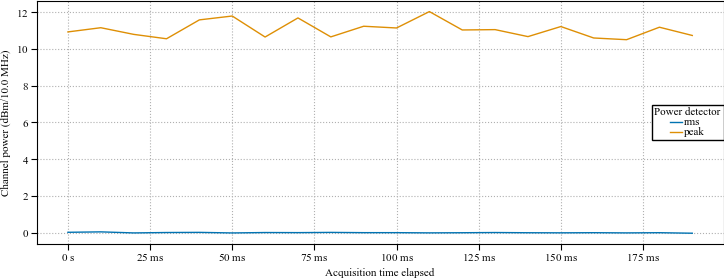

In [27]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analyzer import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [28]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

In [29]:
def profile():
    return channel_waveform.cyclic_channel_power(
        iq,
        sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        cyclic_period=10e-3,
        detector_period=1e-3 / 15 / 4,
        detectors=pvt.power_detector.values,
        cyclic_statistics=('min', 'mean', 'max'),
    )

# benchmark(profile, n_repeat=10)
# benchmark(lambda: profile().to_xarray(), n_repeat=10)

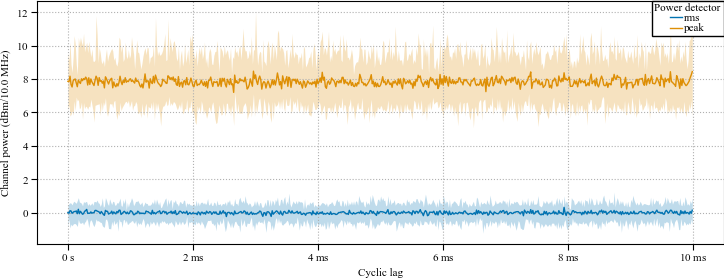

In [30]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [41]:
frequency_resolution = 15e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq,
    sample_rate_Hz=sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    window=('dpss', 5),
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=False,
    dB=True,
).to_xarray()

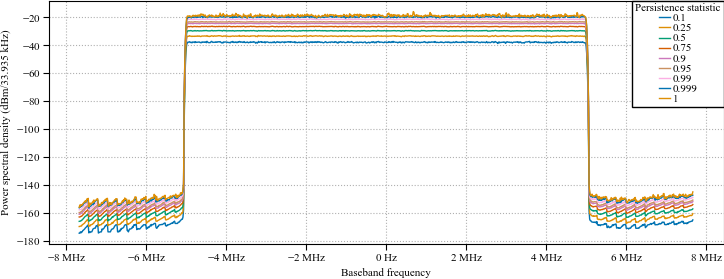

In [40]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

In [33]:
def profile():
    return channel_waveform.persistence_spectrum(
        iq,
        sample_rate_Hz=sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        window=('dpss', 3),
        resolution=frequency_resolution,
        quantiles=spectrum_quantiles,
        fractional_overlap=0.0,
        truncate=True,
        dB=True,
    )

benchmark(profile, n_repeat=10)
# benchmark(lambda: profile().to_xarray(), n_repeat=10)

# %%timeit -n1 -r1

profile             :    CPU: 104196.981 us   +/- 2230.005 (min: 101628.186 / max: 109266.024) us     GPU-0: 104320.731 us   +/- 2197.844 (min: 101687.714 / max: 109330.559) us

### Amplitude Probability Distribution

In [34]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
).to_xarray()

In [35]:
%%timeit -n1 -r1

channel_waveform.amplitude_probability_distribution(
    iq, analysis_bandwidth_Hz=analysis_bandwidth_Hz, **apd_bins
).to_xarray()

20.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


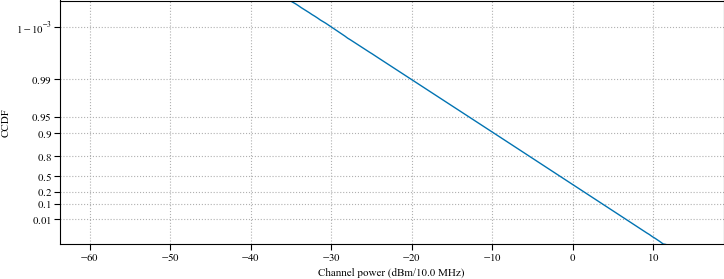

In [36]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [37]:
# %%timeit -n1 -r1

from edge_analyzer import channel_waveform
import importlib
channel_waveform = importlib.reload(channel_waveform)

analysis_spec = {
    'power_time_series': {'detector_period': 10e-3, 'detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    # 'iir': {
    #     'passband_ripple_dB': 0.1,
    #     'stopband_attenuation_dB': 90,
    #     'transition_bandwidth_Hz': 250e3,
    # },
    'ola': {
        'noverlap': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

<xarray.Dataset> Size: 77kB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float64 2kB -40.0 ......
Data variables:
    persistence_spectrum                (persistence_statistic, baseband_frequency) float64 48kB ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    power_time_series                   (power_detector, time_elapsed) float32 160B ...
    amplitude_probability_distribution  (channel_power) float64 2kB 0.9999 .....
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'noverlap': 1024, 'window': 'hamming'}}

In [38]:
%%timeit -n4 -r4

channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

208 ms ± 982 µs per loop (mean ± std. dev. of 4 runs, 4 loops each)
